## Exploratory Analyses

### Imports

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random
from scipy.stats import pearsonr

### Load data

In [49]:
# get puzzle ratings:
puzzles = pd.read_csv("../data/puzzle_ratings_Dec15.csv")
puzzles["date"] = puzzles["date"].apply(pd.Timestamp)

# get rapid ratings:
ratings = pd.read_csv("../data/rapid_ratings_Dec15.csv")
ratings["date"] = ratings["date"].apply(pd.Timestamp)

# get rapid games:
rapid_games = pd.read_csv("../data/rapid_games_Dec15final.csv")
mapping = {
    "username": "category",
    "id": "string",
    "rated": "boolean",
    "status": "category",
    "winner": "category",
    "outcome": "category",
}
rapid_games = rapid_games.astype(mapping)

# convert date strings to date time:
rapid_games["createdAt"] = rapid_games["createdAt"].apply(pd.Timestamp)
rapid_games["lastMoveAt"] = rapid_games["lastMoveAt"].apply(pd.Timestamp)

# convert list strings to python lists:
rapid_games["LAN"] = rapid_games["LAN"].apply(ast.literal_eval)
rapid_games["evaluation"] = rapid_games["evaluation"].apply(ast.literal_eval)
rapid_games["cp_losses"] = rapid_games["cp_losses"].apply(ast.literal_eval)
rapid_games["moveTimes"] = rapid_games["moveTimes"].apply(ast.literal_eval)
rapid_games["dateCreated"] = rapid_games["createdAt"].apply(lambda x: x.to_pydatetime().date())
rapid_games["analysis"] = rapid_games["analysis"].apply(ast.literal_eval)

In [88]:
# only consider the last 6 months of ratings (for which centipawn evaluations are also available)
latest_date = puzzles["date"].max()
puzzles = puzzles[puzzles["date"] > pd.Timestamp(year=latest_date.year, month=latest_date.month - 6, day=latest_date.day)]
puzzles = puzzles[puzzles["username"].isin(rapid_games.username.unique())]
puzzles.reset_index(inplace=True, drop=True)

latest_date = ratings["date"].max()
ratings = ratings[ratings["date"] > pd.Timestamp(year=latest_date.year, month=latest_date.month - 6, day=latest_date.day)]
ratings = ratings[ratings["username"].isin(rapid_games.username.unique())]
ratings.reset_index(inplace=True, drop=True)

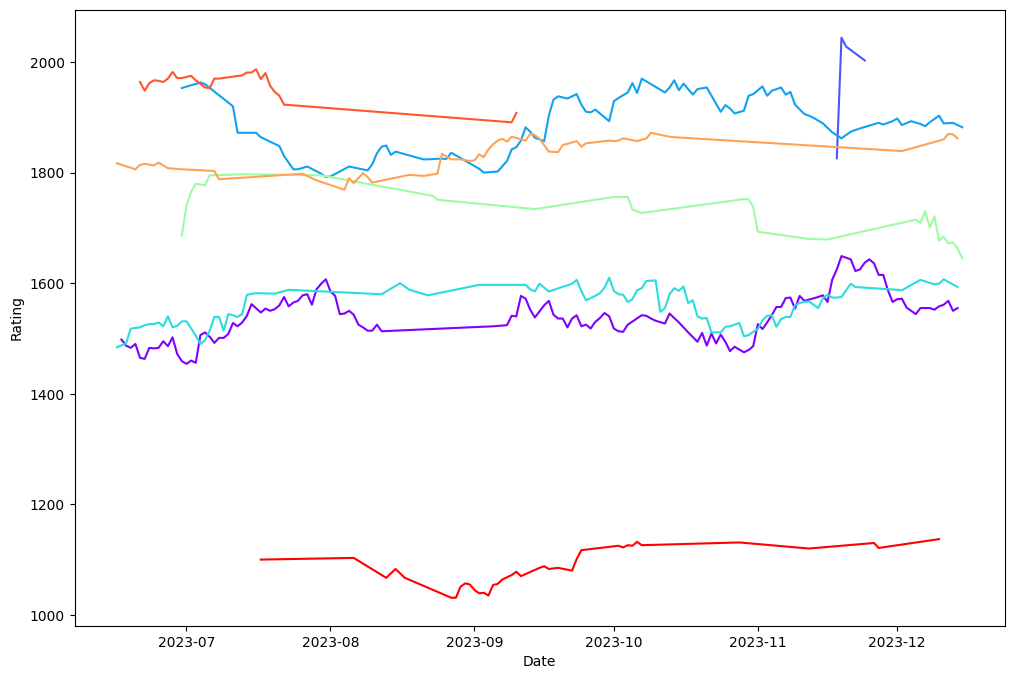

In [87]:
users = random.sample(list(ratings.username.unique()), k=10)
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(users))))

plt.figure(figsize=(12, 8))

for i, user in enumerate(users):
    # subset data by user:
    subset = ratings[ratings['username'] == user]
    # sort ratings by date:
    subset = subset.sort_values(by='date')
    plt.plot(subset['date'], subset['rating'], linestyle='-', color=next(color), label=user)

plt.xlabel('Date')
plt.ylabel('Rating')
plt.show()

## Correlations

### Correlations (averaged for each user)

In [89]:
rapid_games["analysed"] = rapid_games["analysis"].apply(lambda x: 0 if len(x)==0 else 1)

In [94]:
averages = ratings.groupby("username").mean("rating")
averages["games_played"] = rapid_games.groupby("username", observed=False).count()["id"]
averages["prop_analysed"] = rapid_games.groupby("username", observed=False)["analysed"].sum()/averages["games_played"]
averages["avg_cp_loss/game"] = rapid_games.groupby("username", observed=False)["averaged_cp_loss"].mean()
averages["avg_blunders/game"] = rapid_games.groupby("username", observed=False)["blunders"].mean()
averages["puzzle_rating"] = puzzles.groupby("username", observed=False)["rating"].mean()
averages.dropna(inplace=True, how="all")
rho = averages.corr()
pval = averages.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho = rho.round(2).astype(str) + p
rho

C:\Users\phili\AppData\Local\Temp\ipykernel_24448\2260923485.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,rating,games_played,prop_analysed,avg_cp_loss/game,avg_blunders/game,puzzle_rating
rating,1.0***,-0.11,0.23*,-0.73***,-0.66***,0.82***
games_played,-0.11,1.0***,-0.19*,0.14,0.13,-0.28**
prop_analysed,0.23*,-0.19*,1.0***,-0.08,-0.1,0.37***
avg_cp_loss/game,-0.73***,0.14,-0.08,1.0***,0.77***,-0.67***
avg_blunders/game,-0.66***,0.13,-0.1,0.77***,1.0***,-0.62***
puzzle_rating,0.82***,-0.28**,0.37***,-0.67***,-0.62***,1.0***
